Starting simulation for N_CONSUMERS=1000000

--- Running simulation for n_firms = 1 ---
Normal simulation took 4.03s. σ=0.0000
No Sharing simulation took 4.00s.
Results for n=1:
  Normal: CS=0.1250, PS=0.2499, TW=0.3749
  No Sharing: CS=0.1251, PS=0.2500, TW=0.3751

--- Running simulation for n_firms = 2 ---
Normal simulation took 3.85s. σ=0.0000
No Sharing simulation took 3.62s.
Results for n=2:
  Normal: CS=0.2494, PS=0.1785, TW=0.4120
  No Sharing: CS=0.2496, PS=0.1786, TW=0.4122

--- Running simulation for n_firms = 3 ---
Normal simulation took 2.99s. σ=0.2466
No Sharing simulation took 3.88s.
Results for n=3:
  Normal: CS=0.2960, PS=0.1373, TW=0.4116
  No Sharing: CS=0.3659, PS=0.1213, TW=0.4585

--- Running simulation for n_firms = 4 ---
Normal simulation took 2.14s. σ=0.6848
No Sharing simulation took 3.43s.
Results for n=4:
  Normal: CS=0.1985, PS=0.1296, TW=0.3158
  No Sharing: CS=0.4598, PS=0.0826, TW=0.5033

--- Running simulation for n_firms = 5 ---
Normal simulation took 1

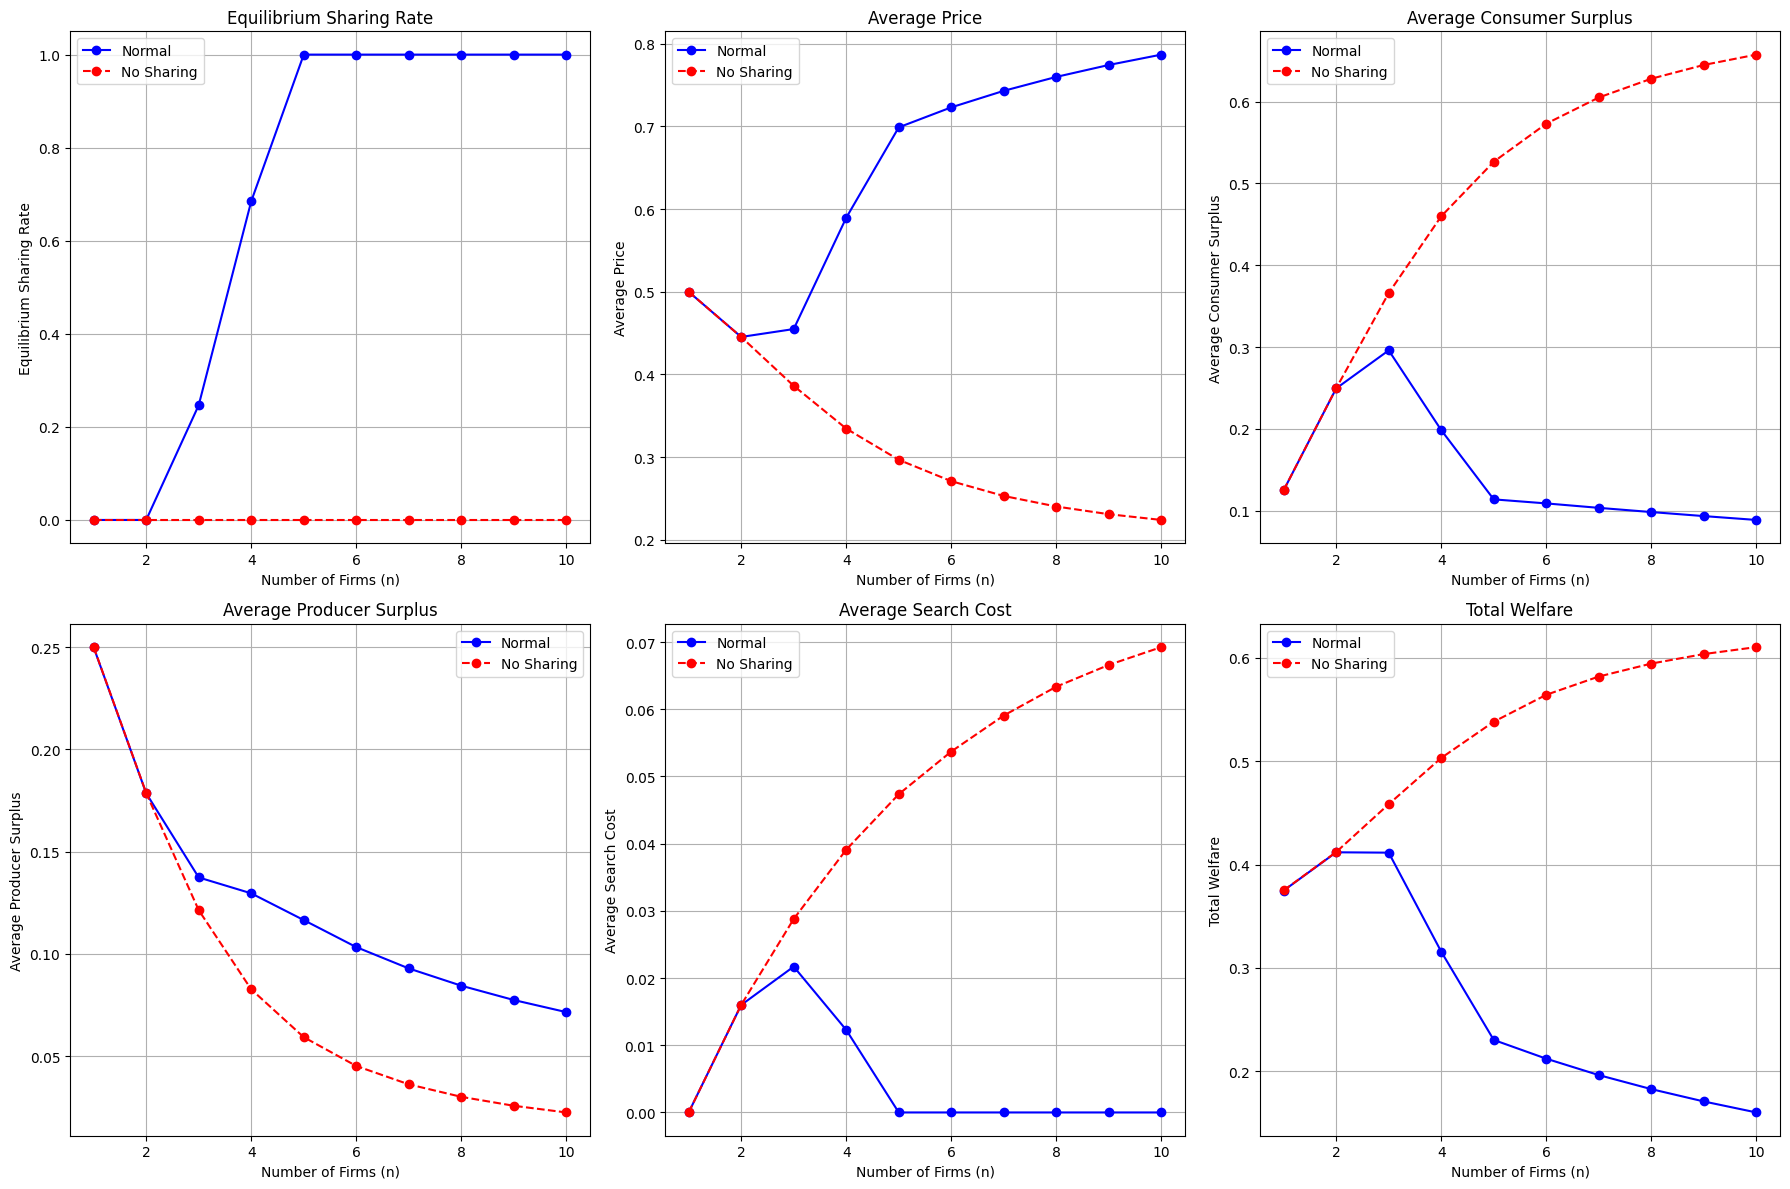

In [2]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import csv
import time # For timing

# --- Constants for consumer behavior (extracted from Consumer class for global access) ---
# These are fixed for a given simulation run based on params
_GLOBAL_V_DIST = None
_GLOBAL_R_VALUE = None
_GLOBAL_N_FIRMS = None
_GLOBAL_SEARCH_COST = None

# Pre-calculate Delta for sharing decision, as it only depends on global params
_GLOBAL_DELTA_SHARING = 0.0

def _calculate_global_delta_sharing():
    """Calculates Delta for sharing decision once."""
    low, high = _GLOBAL_V_DIST['low'], _GLOBAL_V_DIST['high']
    n = _GLOBAL_N_FIRMS
    r = _GLOBAL_R_VALUE

    def integrand(v):
        F_v = (v - low) / (high - low)
        return F_v - F_v ** n

    # Ensure lower bound for quad is at least low, and within distribution range
    r_for_quad = max(r, low)
    if r_for_quad >= high: # If retention value is at or above max valuation, Delta is 0
        return 0.0

    try:
        # Added limit for robustness in numerical integration
        delta, _ = quad(integrand, r_for_quad, high, limit=50)
    except Exception as e:
        print(f"Warning: quad integration failed for Delta calculation (r={r}, n={n}). Error: {e}. Returning 0.")
        delta = 0.0

    # Delta should not be negative in this context, ensure it's at least 0.
    return max(0.0, delta)

class Consumer:
    # Consumer objects will now be very light, mostly just holding their unique tau
    def __init__(self, idx, privacy_cost):
        self.idx = idx
        self.τ = privacy_cost
        self.share = False # Decided later
        self.utility = 0.0
        self.purchase_from = None
        self.search_times = 0

class Firm:
    def __init__(self, idx, marginal_cost, v_dist, r_value):
        self.idx = idx
        self.c = marginal_cost
        self.v_dist = v_dist
        self.r = r_value
        self.price = None
        self.demand = 0.0
        self.profit = 0.0

    def optimize_price(self, σ, n, market_price, global_firm_condition_met=True):
        """
        贝叶斯纳什均衡定价
        :param σ: 数据分享率
        :param n: 企业数量
        :param market_price: 当前市场价格 (for non-shared demand estimation)
        :param global_firm_condition_met: Whether the general condition (r-c > (1-F_r^n)/...) is met.
                                          Calculated once in SimulationPlatform.
        """
        r = self.r
        v_low = self.v_dist['low']
        v_high = self.v_dist['high']

        v_span = v_high - v_low
        if v_span == 0: # Avoid division by zero
            self.price = self.c
            return

        # The 'condition' check is now pre-calculated in SimulationPlatform if it's identical for all firms
        if not global_firm_condition_met:
            # Fallback price: if the general condition for profitable pricing isn't met,
            # firms might price very aggressively or just at retention value/near max valuation.
            self.price = min(r, v_high * 0.999)
            return

        def d_profit_d_pi(p_i, p_avg):
            # Shared demand derivative
            F_pi = np.clip((p_i - v_low) / v_span, 0, 1)
            q_s = (1 - F_pi ** n) / n
            # Derivative of q_s with respect to p_i
            dq_s = -F_pi ** (n - 1) / v_span if F_pi < 1 else 0

            # Non-shared demand and its derivative
            q_ns = self._non_shared_demand(p_i, p_avg, r, n)
            dq_ns = self._deriv_non_shared(p_i, p_avg, r, n)

            Q = σ * q_s + (1 - σ) * q_ns
            dQ = σ * dq_s + (1 - σ) * dq_ns
            return Q + (p_i - self.c) * dQ

        lower_bound = self.c
        upper_bound = r # A reasonable upper bound for price, as consumers won't pay more than r to search

        try:
            # Check the sign of foc at the boundaries to ensure brentq works
            foc_lower = d_profit_d_pi(lower_bound, market_price)
            foc_upper = d_profit_d_pi(upper_bound, market_price)

            # If signs are the same, brentq will fail.
            # This indicates no root or multiple roots, or root outside bracket.
            if foc_lower * foc_upper > 0:
                self.price = np.clip((self.c + r) / 2, lower_bound, upper_bound) # Fallback to midpoint
            else:
                result = root_scalar(
                    lambda p_i: d_profit_d_pi(p_i, market_price),
                    method='brentq',
                    bracket=[lower_bound, upper_bound],
                    maxiter=100
                )
                self.price = result.root
        except Exception as e:
            # Fallback if root finding fails, e.g., no root in bracket or sign error
            self.price = np.clip((self.c + r) / 2, lower_bound, upper_bound)


    def _non_shared_demand(self, p_i, p, r, n):
        v_low = self.v_dist['low']
        v_high = self.v_dist['high']
        v_span = v_high - v_low
        if v_span == 0: return 0.0

        F_r = np.clip((r - v_low) / v_span, 0, 1)

        F_term = np.clip((r - p + p_i - v_low) / v_span, 0, 1)

        numerator = (1 - F_term) * (1 - F_r ** n)
        denominator = n * (1 - F_r)
        term1 = numerator / denominator if denominator > 1e-9 else 0.0

        lower_int = max(p_i, v_low)
        upper_int = min(r - p + p_i, v_high)

        if lower_int >= upper_int:
            term2 = 0.0
        else:
            def integrand(v_i):
                offset = v_i - p_i + p
                F_offset = np.clip((offset - v_low) / v_span, 0, 1)
                return F_offset ** (n - 1) / v_span

            term2, _ = quad(integrand, lower_int, upper_int, limit=50)

        return term1 + term2

    def _deriv_non_shared(self, p_i, p, r, n):
        v_low = self.v_dist['low']
        v_high = self.v_dist['high']
        v_span = v_high - v_low
        if v_span == 0: return 0.0

        F_r = np.clip((r - v_low) / v_span, 0, 1)
        f_density = 1 / v_span

        d_term1 = - f_density * (1 - F_r ** n) / (n * (1 - F_r)) if (1 - F_r) > 1e-9 else 0.0

        lower_bound_integral = max(p_i, v_low)
        upper_bound_integral = min(r - p + p_i, v_high)

        val_at_upper = r - p + p_i
        F_val_at_upper = np.clip((val_at_upper - v_low) / v_span, 0, 1)
        term_upper_boundary = F_val_at_upper ** (n - 1) * f_density if v_low <= val_at_upper <= v_high else 0.0

        val_at_lower = p_i
        F_val_at_lower = np.clip((val_at_lower - v_low) / v_span, 0, 1)
        term_lower_boundary = F_val_at_lower ** (n - 1) * f_density if v_low <= val_at_lower <= v_high else 0.0

        boundary_term = term_upper_boundary - term_lower_boundary

        if lower_bound_integral >= upper_bound_integral or n <= 1:
            integral_of_deriv = 0.0
        else:
            def integrand_of_deriv(v_i):
                offset = v_i - p_i + p
                F_offset = np.clip((offset - v_low) / v_span, 0, 1)
                return - (n - 1) * F_offset ** (n - 2) * (f_density ** 2)

            integral_of_deriv, _ = quad(integrand_of_deriv, lower_bound_integral, upper_bound_integral, limit=50)

        d_term2 = boundary_term + integral_of_deriv

        return d_term1 + d_term2


class SimulationPlatform:
    def __init__(self, n_firms, n_consumers, params):
        global _GLOBAL_V_DIST, _GLOBAL_R_VALUE, _GLOBAL_N_FIRMS, _GLOBAL_SEARCH_COST, _GLOBAL_DELTA_SHARING

        self.n = n_firms
        self.n_consumers = n_consumers
        self.params = params
        self.r = params['r']
        self.s = params['s']

        _GLOBAL_V_DIST = params['v_dist']
        _GLOBAL_R_VALUE = self.r
        _GLOBAL_N_FIRMS = self.n
        _GLOBAL_SEARCH_COST = self.s

        # Pre-calculate delta for sharing decision (only once per simulation run for tau-based decision)
        _GLOBAL_DELTA_SHARING = _calculate_global_delta_sharing()

        self.firms = [Firm(i, params['c'], params['v_dist'], self.r) for i in range(n_firms)]

        self.consumer_taus = np.random.uniform(params['τ_low'], params['τ_high'], n_consumers)
        self.consumers = [Consumer(i, self.consumer_taus[i]) for i in range(n_consumers)]

        v_low, v_high = params['v_dist']['low'], params['v_dist']['high']
        self.all_consumer_valuations = np.random.uniform(v_low, v_high, (n_consumers, n_firms))

        # Robustness for global_firm_condition_met calculation
        if v_high - v_low == 0:
            self.global_firm_condition_met = False
        else:
            F_r = (self.r - v_low) / (v_high - v_low)
            F_r = np.clip(F_r, 0, 1) # Ensure F_r is within [0, 1]
            f_r = 1 / (v_high - v_low)

            denominator_val = self.n * (F_r ** (self.n - 1)) * f_r

            if abs(denominator_val) < 1e-9: # Check for near-zero denominator
                 self.global_firm_condition_met = False
            else:
                self.global_firm_condition_met = (self.r - params['c']) > (1 - F_r ** self.n) / denominator_val


    def run_simulation(self, max_iter=50, tol=1e-7, fixed_sigma_value=None):
        """
        完整模拟流程
        :param fixed_sigma_value: If a float (0.0 to 1.0), force this sharing rate.
                                  If None, consumers decide based on tau.
        """
        start_time = time.time()

        # --- 1. Consumer Data Sharing Decision ---
        if fixed_sigma_value is not None:
            # Force sharing for a fixed_sigma_value proportion of consumers
            num_sharing_consumers = int(self.n_consumers * fixed_sigma_value)
            # Ensure num_sharing_consumers is within valid bounds [0, n_consumers]
            num_sharing_consumers = max(0, min(num_sharing_consumers, self.n_consumers))
            sharing_indices = np.random.choice(self.n_consumers, num_sharing_consumers, replace=False)
            self.consumer_shares = np.zeros(self.n_consumers, dtype=bool)
            self.consumer_shares[sharing_indices] = True
            σ = fixed_sigma_value
        else:
            # Consumers decide based on tau and pre-calculated Delta
            self.consumer_shares = (_GLOBAL_DELTA_SHARING >= self.consumer_taus)
            σ = np.mean(self.consumer_shares)

        # Update individual consumer objects (for consistent state, though mostly handled by numpy arrays)
        for i, c in enumerate(self.consumers):
            c.share = self.consumer_shares[i]

        pricing_start_time = time.time()

        # --- 2. Firm Price Optimization (Iterative Convergence) ---
        prices = np.full(self.n, self.r * 0.9) # Initial prices
        market_price = 0.0 # Initialize market_price here to ensure it's always defined

        if self.n == 1: # Single firm case
            self.firms[0].optimize_price(σ, self.n, prices[0], self.global_firm_condition_met)
            prices[0] = self.firms[0].price
            market_price = prices[0] # Set market_price for n=1 case
        else: # Multiple firms
            for iter_price in range(max_iter):
                current_iteration_market_price = np.mean(prices)
                new_prices = np.empty(self.n)
                for firm_idx, firm in enumerate(self.firms):
                    firm.optimize_price(σ, self.n, current_iteration_market_price, self.global_firm_condition_met)
                    new_prices[firm_idx] = firm.price

                price_diff = np.max(np.abs(new_prices - prices))
                prices = new_prices
                if price_diff < tol:
                    break
            market_price = np.mean(prices) # Set market_price for n > 1 case after convergence

        # print(f"Firm pricing took {time.time() - pricing_start_time:.4f} seconds.")
        consumer_behavior_start_time = time.time()

        # --- 3. Consumer Search and Buy (Optimized for shared/non-shared) ---

        # Shared data consumers:
        shared_consumer_indices = np.where(self.consumer_shares)[0]
        if len(shared_consumer_indices) > 0:
            shared_consumer_valuations = self.all_consumer_valuations[shared_consumer_indices, :]

            max_vals_shared = np.max(shared_consumer_valuations, axis=1)
            buys_shared_mask = max_vals_shared > market_price
            utility_shared = np.where(buys_shared_mask, max_vals_shared - market_price - self.consumer_taus[shared_consumer_indices], -self.consumer_taus[shared_consumer_indices])

            for i, idx in enumerate(shared_consumer_indices):
                self.consumers[idx].utility = utility_shared[i]
                self.consumers[idx].purchase_from = np.argmax(shared_consumer_valuations[i, :]) if buys_shared_mask[i] else None
                self.consumers[idx].search_times = 0 # No search for shared data consumers

        # Non-shared data consumers:
        non_shared_consumer_indices = np.where(~self.consumer_shares)[0]
        if len(non_shared_consumer_indices) > 0:
            non_shared_consumer_valuations = self.all_consumer_valuations[non_shared_consumer_indices, :]
            all_net_utilities = non_shared_consumer_valuations - prices[np.newaxis, :]

            purchase_firm_idx = np.full(len(non_shared_consumer_indices), -1, dtype=int)
            consumer_utilities = np.zeros(len(non_shared_consumer_indices))
            consumer_search_times = np.ones(len(non_shared_consumer_indices), dtype=int)

            search_orders = np.argsort(np.random.rand(len(non_shared_consumer_indices), self.n), axis=1)
            threshold = self.r - market_price
            purchased_mask = np.zeros(len(non_shared_consumer_indices), dtype=bool)

            for search_step in range(self.n):
                if np.all(purchased_mask):
                    break

                active_consumer_indices_in_batch = np.where(~purchased_mask)[0]
                current_firms_to_check = search_orders[active_consumer_indices_in_batch, search_step]
                current_net_utilities = all_net_utilities[active_consumer_indices_in_batch, current_firms_to_check]

                acceptable_mask = current_net_utilities >= threshold
                newly_purchased_indices_in_batch = active_consumer_indices_in_batch[acceptable_mask]

                if len(newly_purchased_indices_in_batch) > 0:
                    purchase_firm_idx[newly_purchased_indices_in_batch] = current_firms_to_check[acceptable_mask]
                    consumer_utilities[newly_purchased_indices_in_batch] = current_net_utilities[acceptable_mask]
                    consumer_search_times[newly_purchased_indices_in_batch] = search_step + 1
                    purchased_mask[newly_purchased_indices_in_batch] = True

            unpurchased_final_mask = (purchase_firm_idx == -1) & (~purchased_mask)
            if np.any(unpurchased_final_mask):
                unpurchased_indices_in_batch = np.where(unpurchased_final_mask)[0]
                for consumer_batch_idx in unpurchased_indices_in_batch:
                    # Consumer has searched all N firms
                    searched_firms_for_consumer = search_orders[consumer_batch_idx, :self.n]
                    net_u_for_searched = all_net_utilities[consumer_batch_idx, searched_firms_for_consumer]

                    if len(net_u_for_searched) > 0:
                        max_net_u = np.max(net_u_for_searched)
                        if max_net_u > 0:
                            best_firm_idx_in_search_path = searched_firms_for_consumer[np.argmax(net_u_for_searched)]
                            purchase_firm_idx[consumer_batch_idx] = best_firm_idx_in_search_path
                            consumer_utilities[consumer_batch_idx] = max_net_u
                        else:
                            consumer_utilities[consumer_batch_idx] = 0.0
                    else:
                        consumer_utilities[consumer_batch_idx] = 0.0
                    consumer_search_times[consumer_batch_idx] = self.n # Always N searches if no purchase before

            for i, global_idx in enumerate(non_shared_consumer_indices):
                self.consumers[global_idx].utility = consumer_utilities[i]
                self.consumers[global_idx].purchase_from = int(purchase_firm_idx[i]) if purchase_firm_idx[i] != -1 else None
                self.consumers[global_idx].search_times = consumer_search_times[i]

        # print(f"Consumer search and buy took {time.time() - consumer_behavior_start_time:.4f} seconds.")

        # --- 4. Calculate Demand and Profit ---
        firm_purchase_counts = np.zeros(self.n, dtype=int)
        all_purchase_from_indices = np.array([c.purchase_from if c.purchase_from is not None else -1 for c in self.consumers])

        valid_purchases = all_purchase_from_indices[all_purchase_from_indices != -1]
        if len(valid_purchases) > 0:
            counts = np.bincount(valid_purchases, minlength=self.n)
            firm_purchase_counts = counts[:self.n]

        for firm_idx, firm in enumerate(self.firms):
            firm.demand = firm_purchase_counts[firm_idx] / self.n_consumers
            firm.profit = (firm.price - firm.c) * firm.demand

        # --- 5. Calculate Aggregated Metrics ---
        total_consumer_surplus = sum(c.utility for c in self.consumers)
        total_producer_surplus = sum(f.profit for f in self.firms)
        avg_consumer_surplus = total_consumer_surplus / self.n_consumers
        avg_producer_surplus = total_producer_surplus / self.n

        total_search_cost = sum(max(c.search_times - 1, 0) * self.s for c in self.consumers if not c.share)
        avg_search_cost = total_search_cost / self.n_consumers

        # print(f"Aggregation took {time.time() - consumer_behavior_start_time:.4f} seconds.")
        # print(f"Total simulation time: {time.time() - start_time:.4f} seconds.")

        return {
            'σ': σ,
            'prices': prices.tolist(),
            'avg_price': np.mean(prices),
            'avg_consumer_surplus': avg_consumer_surplus,
            'avg_producer_surplus': avg_producer_surplus,
            'avg_search_cost': avg_search_cost,
            'total_welfare': avg_consumer_surplus + avg_producer_surplus - avg_search_cost # Define total welfare
        }

if __name__ == "__main__":
    # 参数配置
    params = {
        'v_dist': {'type': 'uniform', 'low': 0, 'high': 1},
        'τ_low': 0.025,
        'τ_high': 0.055,
        'c': 0.0,
        'r': 0.8,
        's': 0.02  # 搜索成本
    }

    n_list = list(range(1, 11)) # Number of firms from 1 to 10
    N_CONSUMERS_SIM = 1000000 # Number of consumers for each simulation run

    # 仅保留两个情景：Normal 与 No_Sharing
    all_results = {
        'Normal': {'σ': [], 'avg_price': [], 'avg_consumer_surplus': [], 'avg_producer_surplus': [], 'avg_search_cost': [], 'total_welfare': []},
        'No_Sharing': {'σ': [], 'avg_price': [], 'avg_consumer_surplus': [], 'avg_producer_surplus': [], 'avg_search_cost': [], 'total_welfare': []},
    }

    print(f"Starting simulation for N_CONSUMERS={N_CONSUMERS_SIM}")
    for n in n_list:
        print(f"\n--- Running simulation for n_firms = {n} ---")

        # 情景 1: Normal
        start_time_scenario = time.time()
        sim_normal = SimulationPlatform(n_firms=n, n_consumers=N_CONSUMERS_SIM, params=params)
        results_normal = sim_normal.run_simulation()
        for key in all_results['Normal'].keys():
            all_results['Normal'][key].append(results_normal.get(key, np.nan))
        print(f"Normal simulation took {time.time() - start_time_scenario:.2f}s. σ={results_normal['σ']:.4f}")

        # 情景 2: No Sharing (σ 固定为 0)
        start_time_scenario = time.time()
        sim_no_sharing = SimulationPlatform(n_firms=n, n_consumers=N_CONSUMERS_SIM, params=params)
        results_no_sharing = sim_no_sharing.run_simulation(fixed_sigma_value=0.0)
        for key in all_results['No_Sharing'].keys():
            all_results['No_Sharing'][key].append(results_no_sharing.get(key, np.nan))
        print(f"No Sharing simulation took {time.time() - start_time_scenario:.2f}s.")

        print(f"Results for n={n}:")
        print(f"  Normal: CS={all_results['Normal']['avg_consumer_surplus'][-1]:.4f}, PS={all_results['Normal']['avg_producer_surplus'][-1]:.4f}, TW={all_results['Normal']['total_welfare'][-1]:.4f}")
        print(f"  No Sharing: CS={all_results['No_Sharing']['avg_consumer_surplus'][-1]:.4f}, PS={all_results['No_Sharing']['avg_producer_surplus'][-1]:.4f}, TW={all_results['No_Sharing']['total_welfare'][-1]:.4f}")

    # --- CSV 保存 ---
    csv_filename = "multi_scenario_simulation_results_optimized.csv"
    with open(csv_filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=' ')
        csvwriter.writerow(["# Experiment Configuration: Two-Scenario Simulation (Normal vs No_Sharing)"])
        csvwriter.writerow([f"# N_Consumers: {N_CONSUMERS_SIM}"])
        csvwriter.writerow([f"# Parameters: {params}"])
        csvwriter.writerow(["# Each row represents a 'Number of Firms (n)' value."])
        csvwriter.writerow(["# Metrics per scenario: share_ratio (sigma), avg_consumer_surplus, avg_producer_surplus, avg_search_cost, avg_price, total_welfare."])

        headers = ["Firm_Num"]
        metrics_to_save = ['σ', 'avg_consumer_surplus', 'avg_producer_surplus', 'avg_search_cost', 'avg_price', 'total_welfare']
        scenarios_to_include_in_csv = ['Normal', 'No_Sharing']
        scenario_prefixes = { 'Normal': 'Normal', 'No_Sharing': 'NoSharing' }

        for scenario_key in scenarios_to_include_in_csv:
            for metric_name in metrics_to_save:
                if metric_name == 'σ':
                    header_suffix = 'share_ratio'
                elif metric_name == 'avg_consumer_surplus':
                    header_suffix = 'consumer_surplus'
                elif metric_name == 'avg_producer_surplus':
                    header_suffix = 'firm_surplus'
                elif metric_name == 'avg_search_cost':
                    header_suffix = 'avg_search_cost'
                elif metric_name == 'avg_price':
                    header_suffix = 'avg_price'
                elif metric_name == 'total_welfare':
                    header_suffix = 'total_welfare'
                else:
                    header_suffix = metric_name
                headers.append(f"{scenario_prefixes[scenario_key]}_{header_suffix}")
        csvwriter.writerow(headers)

        for i, n in enumerate(n_list):
            data_row = [n]
            for scenario_key in scenarios_to_include_in_csv:
                data_row.extend([
                    all_results[scenario_key]['σ'][i],
                    all_results[scenario_key]['avg_consumer_surplus'][i],
                    all_results[scenario_key]['avg_producer_surplus'][i],
                    all_results[scenario_key]['avg_search_cost'][i],
                    all_results[scenario_key]['avg_price'][i],
                    all_results[scenario_key]['total_welfare'][i]
                ])
            formatted_row = [f"{value:.6f}" if isinstance(value, (float, np.floating)) else str(value) for value in data_row]
            csvwriter.writerow(formatted_row)

    print(f"\nSimulation results saved to '{csv_filename}'")

    # --- 绘图 ---
    plt.figure(figsize=(18, 12))
    metrics_to_plot = ['σ', 'avg_price', 'avg_consumer_surplus', 'avg_producer_surplus', 'avg_search_cost', 'total_welfare']
    plot_titles = ['Equilibrium Sharing Rate', 'Average Price', 'Average Consumer Surplus', 'Average Producer Surplus', 'Average Search Cost', 'Total Welfare']
    colors = {'Normal': 'blue', 'No_Sharing': 'red'}
    linestyles = {'Normal': '-', 'No_Sharing': '--'}

    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 3, i + 1)
        for scenario_key, scenario_data in all_results.items():
            plt.plot(n_list, scenario_data[metric], marker='o',
                     color=colors[scenario_key], linestyle=linestyles[scenario_key],
                     label=f'{scenario_key.replace("_", " ")}')
        plt.title(plot_titles[i])
        plt.xlabel('Number of Firms (n)')
        plt.ylabel(plot_titles[i])
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig('multi_scenario_simulation_results.png')
    plt.show()


Starting simulation for N_CONSUMERS=100000

--- n_firms = 1 ---
Normal: Price=0.5000, PS=0.2513
No Sharing: Price=0.5000, PS=0.2494
Collusion: Price=0.5000, PS=0.2500

--- n_firms = 2 ---
Normal: Price=0.4454, PS=0.1784
No Sharing: Price=0.4454, PS=0.1785
Collusion: Price=0.5774, PS=0.1929

--- n_firms = 3 ---
Normal: Price=0.4550, PS=0.1374
No Sharing: Price=0.3862, PS=0.1213
Collusion: Price=0.6300, PS=0.1578

--- n_firms = 4 ---
Normal: Price=0.5894, PS=0.1296
No Sharing: Price=0.3345, PS=0.0826
Collusion: Price=0.6687, PS=0.1334

--- n_firms = 5 ---
Normal: Price=0.6988, PS=0.1165
No Sharing: Price=0.2968, PS=0.0592
Collusion: Price=0.6988, PS=0.1163

--- n_firms = 6 ---
Normal: Price=0.7230, PS=0.1033
No Sharing: Price=0.2709, PS=0.0451
Collusion: Price=0.7230, PS=0.1032

--- n_firms = 7 ---
Normal: Price=0.7430, PS=0.0929
No Sharing: Price=0.2531, PS=0.0361
Collusion: Price=0.7430, PS=0.0927

--- n_firms = 8 ---
Normal: Price=0.7598, PS=0.0844
No Sharing: Price=0.2403, PS=0.0300


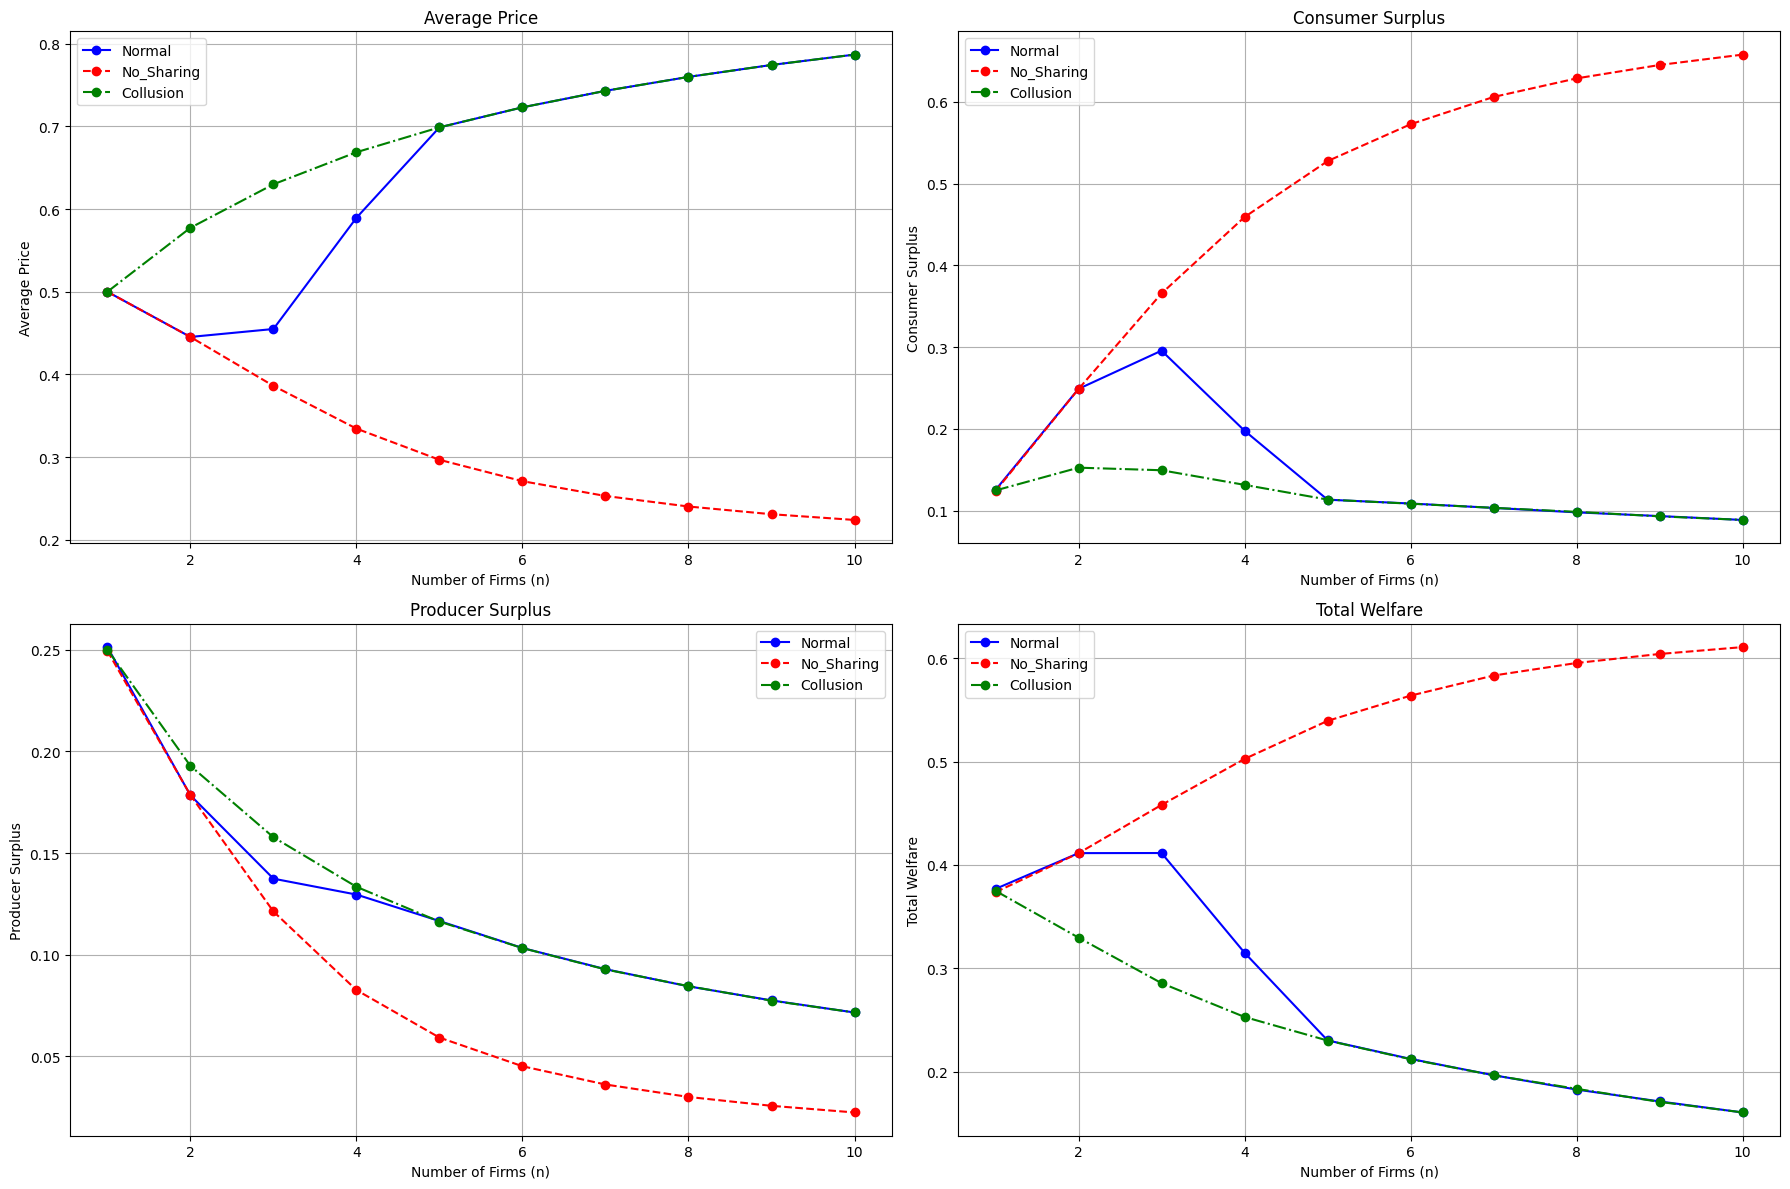

In [2]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import csv
import time

# --- Constants ---
_GLOBAL_V_DIST = None
_GLOBAL_R_VALUE = None
_GLOBAL_N_FIRMS = None
_GLOBAL_SEARCH_COST = None
_GLOBAL_DELTA_SHARING = 0.0

def _calculate_global_delta_sharing():
    low, high = _GLOBAL_V_DIST['low'], _GLOBAL_V_DIST['high']
    n = _GLOBAL_N_FIRMS
    r = _GLOBAL_R_VALUE

    def integrand(v):
        F_v = (v - low) / (high - low)
        return F_v - F_v ** n

    r_for_quad = max(r, low)
    if r_for_quad >= high:
        return 0.0

    try:
        delta, _ = quad(integrand, r_for_quad, high, limit=50)
    except Exception as e:
        delta = 0.0

    return max(0.0, delta)

class Consumer:
    def __init__(self, idx, privacy_cost):
        self.idx = idx
        self.τ = privacy_cost
        self.share = False
        self.utility = 0.0
        self.purchase_from = None
        self.search_times = 0

class Firm:
    def __init__(self, idx, marginal_cost, v_dist, r_value):
        self.idx = idx
        self.c = marginal_cost
        self.v_dist = v_dist
        self.r = r_value
        self.price = None
        self.demand = 0.0
        self.profit = 0.0

    def optimize_price(self, σ, n, market_price, global_firm_condition_met=True, mode='competition'):
        r = self.r
        v_low = self.v_dist['low']
        v_high = self.v_dist['high']
        v_span = v_high - v_low

        if v_span == 0:
            self.price = self.c
            return

        if not global_firm_condition_met:
            self.price = min(r, v_high * 0.999)
            return

        # ============================
        # 模式 1: 合谋 (Collusion)
        # ============================
        if mode == 'collusion':
            # 修正点：重新定义合谋下的导数函数，移除错误的边界截断
            def d_profit_collusion(p):
                # 限制 F_p 在 [0, 1] 之间，防止数值越界
                F_p = np.clip((p - v_low) / v_span, 0, 1)
                f_density = 1 / v_span

                # 1. 计算每个企业的销量份额: q_share = (1 - F^n) / n
                q_share = (1 - F_p ** n) / n

                # 2. 计算销量的导数: dq/dp
                # d(Total_Q)/dp = -n * F^(n-1) * f
                # dq_share/dp = d(Total_Q)/dp / n = - F^(n-1) * f

                # 注意：如果 n=1, F^(n-1) = F^0 = 1
                # 如果 n>1 且 F=0, F^(n-1) = 0
                if n == 1:
                    dq_share_dp = -f_density
                else:
                    dq_share_dp = - (F_p ** (n - 1)) * f_density

                # 3. 边际利润方程: MR = q + (p-c)*dq/dp
                return q_share + (p - self.c) * dq_share_dp

            lower_bound = self.c
            upper_bound = r

            try:
                # 检查边界导数符号
                foc_lower = d_profit_collusion(lower_bound) # p=0 时，MR 应该 > 0
                foc_upper = d_profit_collusion(upper_bound) # p=r 时，MR 可能 < 0

                if foc_lower * foc_upper > 0:
                    # 如果两者同号（通常都是正数，意味着利润随着价格一直增加直到 r），则取 r
                    if foc_lower > 0:
                        self.price = upper_bound
                    else:
                        self.price = lower_bound
                else:
                    res = root_scalar(d_profit_collusion, bracket=[lower_bound, upper_bound], method='brentq')
                    self.price = res.root
            except Exception as e:
                # 如果求解失败，通常是因为函数单调，直接取利润更高的边界（通常是上限）
                self.price = upper_bound

            return

        # ============================
        # 模式 2: 竞争 (Competition / Nash)
        # ============================
        else:
            def d_profit_d_pi(p_i, p_avg):
                F_pi = np.clip((p_i - v_low) / v_span, 0, 1)
                q_s = (1 - F_pi ** n) / n
                dq_s = -F_pi ** (n - 1) / v_span if F_pi < 1 else 0

                q_ns = self._non_shared_demand(p_i, p_avg, r, n)
                dq_ns = self._deriv_non_shared(p_i, p_avg, r, n)

                Q = σ * q_s + (1 - σ) * q_ns
                dQ = σ * dq_s + (1 - σ) * dq_ns
                return Q + (p_i - self.c) * dQ

            lower_bound = self.c
            upper_bound = r

            try:
                foc_lower = d_profit_d_pi(lower_bound, market_price)
                foc_upper = d_profit_d_pi(upper_bound, market_price)

                if foc_lower * foc_upper > 0:
                    self.price = np.clip((self.c + r) / 2, lower_bound, upper_bound)
                else:
                    result = root_scalar(
                        lambda p_i: d_profit_d_pi(p_i, market_price),
                        method='brentq',
                        bracket=[lower_bound, upper_bound],
                        maxiter=100
                    )
                    self.price = result.root
            except Exception:
                self.price = np.clip((self.c + r) / 2, lower_bound, upper_bound)

    def _non_shared_demand(self, p_i, p, r, n):
        v_low = self.v_dist['low']
        v_high = self.v_dist['high']
        v_span = v_high - v_low
        if v_span == 0: return 0.0

        F_r = np.clip((r - v_low) / v_span, 0, 1)
        F_term = np.clip((r - p + p_i - v_low) / v_span, 0, 1)

        numerator = (1 - F_term) * (1 - F_r ** n)
        denominator = n * (1 - F_r)
        term1 = numerator / denominator if denominator > 1e-9 else 0.0

        lower_int = max(p_i, v_low)
        upper_int = min(r - p + p_i, v_high)

        if lower_int >= upper_int:
            term2 = 0.0
        else:
            def integrand(v_i):
                offset = v_i - p_i + p
                F_offset = np.clip((offset - v_low) / v_span, 0, 1)
                return F_offset ** (n - 1) / v_span

            term2, _ = quad(integrand, lower_int, upper_int, limit=50)

        return term1 + term2

    def _deriv_non_shared(self, p_i, p, r, n):
        v_low = self.v_dist['low']
        v_high = self.v_dist['high']
        v_span = v_high - v_low
        if v_span == 0: return 0.0

        F_r = np.clip((r - v_low) / v_span, 0, 1)
        f_density = 1 / v_span

        d_term1 = - f_density * (1 - F_r ** n) / (n * (1 - F_r)) if (1 - F_r) > 1e-9 else 0.0

        lower_bound_integral = max(p_i, v_low)
        upper_bound_integral = min(r - p + p_i, v_high)

        val_at_upper = r - p + p_i
        F_val_at_upper = np.clip((val_at_upper - v_low) / v_span, 0, 1)
        term_upper_boundary = F_val_at_upper ** (n - 1) * f_density if v_low <= val_at_upper <= v_high else 0.0

        val_at_lower = p_i
        F_val_at_lower = np.clip((val_at_lower - v_low) / v_span, 0, 1)
        term_lower_boundary = F_val_at_lower ** (n - 1) * f_density if v_low <= val_at_lower <= v_high else 0.0

        boundary_term = term_upper_boundary - term_lower_boundary

        if lower_bound_integral >= upper_bound_integral or n <= 1:
            integral_of_deriv = 0.0
        else:
            def integrand_of_deriv(v_i):
                offset = v_i - p_i + p
                F_offset = np.clip((offset - v_low) / v_span, 0, 1)
                return - (n - 1) * F_offset ** (n - 2) * (f_density ** 2)

            integral_of_deriv, _ = quad(integrand_of_deriv, lower_bound_integral, upper_bound_integral, limit=50)

        d_term2 = boundary_term + integral_of_deriv
        return d_term1 + d_term2


class SimulationPlatform:
    def __init__(self, n_firms, n_consumers, params):
        global _GLOBAL_V_DIST, _GLOBAL_R_VALUE, _GLOBAL_N_FIRMS, _GLOBAL_SEARCH_COST, _GLOBAL_DELTA_SHARING

        self.n = n_firms
        self.n_consumers = n_consumers
        self.params = params
        self.r = params['r']
        self.s = params['s']

        _GLOBAL_V_DIST = params['v_dist']
        _GLOBAL_R_VALUE = self.r
        _GLOBAL_N_FIRMS = self.n
        _GLOBAL_SEARCH_COST = self.s
        _GLOBAL_DELTA_SHARING = _calculate_global_delta_sharing()

        self.firms = [Firm(i, params['c'], params['v_dist'], self.r) for i in range(n_firms)]

        self.consumer_taus = np.random.uniform(params['τ_low'], params['τ_high'], n_consumers)
        self.consumers = [Consumer(i, self.consumer_taus[i]) for i in range(n_consumers)]

        v_low, v_high = params['v_dist']['low'], params['v_dist']['high']
        self.all_consumer_valuations = np.random.uniform(v_low, v_high, (n_consumers, n_firms))

        if v_high - v_low == 0:
            self.global_firm_condition_met = False
        else:
            F_r = (self.r - v_low) / (v_high - v_low)
            F_r = np.clip(F_r, 0, 1)
            f_r = 1 / (v_high - v_low)
            denominator_val = self.n * (F_r ** (self.n - 1)) * f_r
            if abs(denominator_val) < 1e-9:
                 self.global_firm_condition_met = False
            else:
                self.global_firm_condition_met = (self.r - params['c']) > (1 - F_r ** self.n) / denominator_val

    def run_simulation(self, max_iter=50, tol=1e-7, fixed_sigma_value=None, mode='competition'):
        start_time = time.time()

        # --- 1. Consumer Data Sharing Decision ---
        if fixed_sigma_value is not None:
            num_sharing_consumers = int(self.n_consumers * fixed_sigma_value)
            num_sharing_consumers = max(0, min(num_sharing_consumers, self.n_consumers))
            sharing_indices = np.random.choice(self.n_consumers, num_sharing_consumers, replace=False)
            self.consumer_shares = np.zeros(self.n_consumers, dtype=bool)
            self.consumer_shares[sharing_indices] = True
            σ = fixed_sigma_value
        else:
            self.consumer_shares = (_GLOBAL_DELTA_SHARING >= self.consumer_taus)
            σ = np.mean(self.consumer_shares)

        for i, c in enumerate(self.consumers):
            c.share = self.consumer_shares[i]

        # --- 2. Firm Price Optimization ---
        prices = np.full(self.n, self.r * 0.9)
        market_price = 0.0

        if mode == 'collusion':
            # 合谋模式：只需计算一次
            self.firms[0].optimize_price(σ, self.n, prices[0], self.global_firm_condition_met, mode='collusion')
            collusion_price = self.firms[0].price

            # 确保合谋价格被应用
            prices = np.full(self.n, collusion_price)
            for f in self.firms:
                f.price = collusion_price
            market_price = collusion_price

        else:
            # 竞争模式
            if self.n == 1:
                self.firms[0].optimize_price(σ, self.n, prices[0], self.global_firm_condition_met, mode='competition')
                prices[0] = self.firms[0].price
                market_price = prices[0]
            else:
                for iter_price in range(max_iter):
                    current_iteration_market_price = np.mean(prices)
                    new_prices = np.empty(self.n)
                    for firm_idx, firm in enumerate(self.firms):
                        firm.optimize_price(σ, self.n, current_iteration_market_price, self.global_firm_condition_met, mode='competition')
                        new_prices[firm_idx] = firm.price

                    price_diff = np.max(np.abs(new_prices - prices))
                    prices = new_prices
                    if price_diff < tol:
                        break
                market_price = np.mean(prices)

        # --- 3. Consumer Search and Buy ---
        # Shared data consumers
        shared_consumer_indices = np.where(self.consumer_shares)[0]
        if len(shared_consumer_indices) > 0:
            shared_consumer_valuations = self.all_consumer_valuations[shared_consumer_indices, :]
            max_vals_shared = np.max(shared_consumer_valuations, axis=1)
            buys_shared_mask = max_vals_shared > market_price
            utility_shared = np.where(buys_shared_mask, max_vals_shared - market_price - self.consumer_taus[shared_consumer_indices], -self.consumer_taus[shared_consumer_indices])

            for i, idx in enumerate(shared_consumer_indices):
                self.consumers[idx].utility = utility_shared[i]
                self.consumers[idx].purchase_from = np.argmax(shared_consumer_valuations[i, :]) if buys_shared_mask[i] else None
                # Shared consumers don't search, cost is tau (already subtracted in utility)
                self.consumers[idx].search_times = 1 # Mark as 1 "visit" for consistency, but cost logic handles tau separate

        # Non-shared data consumers
        non_shared_consumer_indices = np.where(~self.consumer_shares)[0]
        if len(non_shared_consumer_indices) > 0:
            non_shared_consumer_valuations = self.all_consumer_valuations[non_shared_consumer_indices, :]
            all_net_utilities = non_shared_consumer_valuations - prices[np.newaxis, :]
            purchase_firm_idx = np.full(len(non_shared_consumer_indices), -1, dtype=int)
            consumer_utilities = np.zeros(len(non_shared_consumer_indices))
            consumer_search_times = np.ones(len(non_shared_consumer_indices), dtype=int)
            search_orders = np.argsort(np.random.rand(len(non_shared_consumer_indices), self.n), axis=1)
            threshold = self.r - market_price
            purchased_mask = np.zeros(len(non_shared_consumer_indices), dtype=bool)

            for search_step in range(self.n):
                if np.all(purchased_mask): break
                active = np.where(~purchased_mask)[0]
                current_firms = search_orders[active, search_step]
                current_net_u = all_net_utilities[active, current_firms]
                acceptable = current_net_u >= threshold
                newly_purchased = active[acceptable]
                if len(newly_purchased) > 0:
                    purchase_firm_idx[newly_purchased] = current_firms[acceptable]
                    consumer_utilities[newly_purchased] = current_net_u[acceptable]
                    consumer_search_times[newly_purchased] = search_step + 1
                    purchased_mask[newly_purchased] = True

            unpurchased = np.where((purchase_firm_idx == -1) & (~purchased_mask))[0]
            if len(unpurchased) > 0:
                for idx in unpurchased:
                    searched = search_orders[idx, :self.n]
                    vals = all_net_utilities[idx, searched]
                    if len(vals) > 0 and np.max(vals) > 0:
                        purchase_firm_idx[idx] = searched[np.argmax(vals)]
                        consumer_utilities[idx] = np.max(vals)
                    consumer_search_times[idx] = self.n

            for i, global_idx in enumerate(non_shared_consumer_indices):
                self.consumers[global_idx].utility = consumer_utilities[i]
                self.consumers[global_idx].purchase_from = int(purchase_firm_idx[i]) if purchase_firm_idx[i] != -1 else None
                self.consumers[global_idx].search_times = consumer_search_times[i]

        # --- 4. Demand and Profit ---
        firm_purchase_counts = np.zeros(self.n, dtype=int)
        all_purchases = np.array([c.purchase_from if c.purchase_from is not None else -1 for c in self.consumers])
        valid_purchases = all_purchases[all_purchases != -1]
        if len(valid_purchases) > 0:
            firm_purchase_counts = np.bincount(valid_purchases, minlength=self.n)[:self.n]

        for firm_idx, firm in enumerate(self.firms):
            firm.demand = firm_purchase_counts[firm_idx] / self.n_consumers
            firm.profit = (firm.price - firm.c) * firm.demand

        # --- 5. Aggregation ---
        total_cs = sum(c.utility for c in self.consumers)
        total_ps = sum(f.profit for f in self.firms)
        avg_cs = total_cs / self.n_consumers
        avg_ps = total_ps / self.n
        # Fix: Search cost only for non-sharing consumers. search_times-1 because 1st search is free/entry?
        # Usually s is per search. If consumer searches 1 firm, cost is s? Or 0?
        # Standard models: First search is often sunk or s per sample. Assuming s per sample here.
        # But commonly in diamond paradox models, first search is free or s.
        # Using "max(search_times - 1, 0)" implies first search is free. Let's stick to that if that was intended.
        total_search = sum(max(c.search_times - 1, 0) * self.s for c in self.consumers if not c.share)
        avg_search = total_search / self.n_consumers

        return {
            'σ': σ,
            'prices': prices.tolist(),
            'avg_price': np.mean(prices),
            'avg_consumer_surplus': avg_cs,
            'avg_producer_surplus': avg_ps,
            'avg_search_cost': avg_search,
            'total_welfare': avg_cs + avg_ps - avg_search
        }

if __name__ == "__main__":
    params = {
        'v_dist': {'type': 'uniform', 'low': 0, 'high': 1},
        'τ_low': 0.025,
        'τ_high': 0.055,
        'c': 0.0,
        'r': 0.8,
        's': 0.02
    }

    n_list = list(range(1, 11))
    N_CONSUMERS_SIM = 100000

    all_results = {
        'Normal': {'σ': [], 'avg_price': [], 'avg_consumer_surplus': [], 'avg_producer_surplus': [], 'avg_search_cost': [], 'total_welfare': []},
        'No_Sharing': {'σ': [], 'avg_price': [], 'avg_consumer_surplus': [], 'avg_producer_surplus': [], 'avg_search_cost': [], 'total_welfare': []},
        'Collusion': {'σ': [], 'avg_price': [], 'avg_consumer_surplus': [], 'avg_producer_surplus': [], 'avg_search_cost': [], 'total_welfare': []}
    }

    print(f"Starting simulation for N_CONSUMERS={N_CONSUMERS_SIM}")
    for n in n_list:
        print(f"\n--- n_firms = {n} ---")

        # 1. Normal
        sim_normal = SimulationPlatform(n, N_CONSUMERS_SIM, params)
        res_normal = sim_normal.run_simulation(mode='competition')
        for k in all_results['Normal']: all_results['Normal'][k].append(res_normal.get(k, np.nan))
        print(f"Normal: Price={res_normal['avg_price']:.4f}, PS={res_normal['avg_producer_surplus']:.4f}")

        # 2. No Sharing
        sim_no = SimulationPlatform(n, N_CONSUMERS_SIM, params)
        res_no = sim_no.run_simulation(fixed_sigma_value=0.0, mode='competition')
        for k in all_results['No_Sharing']: all_results['No_Sharing'][k].append(res_no.get(k, np.nan))
        print(f"No Sharing: Price={res_no['avg_price']:.4f}, PS={res_no['avg_producer_surplus']:.4f}")

        # 3. Collusion
        sim_col = SimulationPlatform(n, N_CONSUMERS_SIM, params)
        res_col = sim_col.run_simulation(mode='collusion')
        for k in all_results['Collusion']: all_results['Collusion'][k].append(res_col.get(k, np.nan))
        print(f"Collusion: Price={res_col['avg_price']:.4f}, PS={res_col['avg_producer_surplus']:.4f}")

    # --- CSV Save ---
    csv_filename = "simulation_results_with_collusion_fixed.csv"
    with open(csv_filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        headers = ["Firm_Num"]
        scenarios = ['Normal', 'No_Sharing', 'Collusion']
        metrics = ['avg_price', 'avg_consumer_surplus', 'avg_producer_surplus', 'total_welfare']

        for sc in scenarios:
            for m in metrics:
                headers.append(f"{sc}_{m}")
        csvwriter.writerow(headers)

        for i, n in enumerate(n_list):
            row = [n]
            for sc in scenarios:
                for m in metrics:
                    row.append(f"{all_results[sc][m][i]:.6f}")
            csvwriter.writerow(row)
    print(f"\nSaved to {csv_filename}")

    # --- Plotting ---
    plt.figure(figsize=(18, 12))
    metrics_plot = ['avg_price', 'avg_consumer_surplus', 'avg_producer_surplus', 'total_welfare']
    titles = ['Average Price', 'Consumer Surplus', 'Producer Surplus', 'Total Welfare']
    colors = {'Normal': 'blue', 'No_Sharing': 'red', 'Collusion': 'green'}
    styles = {'Normal': '-', 'No_Sharing': '--', 'Collusion': '-.'}

    for i, metric in enumerate(metrics_plot):
        plt.subplot(2, 2, i + 1)
        for sc in all_results:
            plt.plot(n_list, all_results[sc][metric], label=sc, color=colors[sc], linestyle=styles[sc], marker='o')
        plt.title(titles[i])
        plt.xlabel('Number of Firms (n)')
        plt.ylabel(titles[i])
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig('collusion_simulation_fixed.png')
    plt.show()